In [91]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import display, Markdown




def load_datasets(file_names):

    datasets = {}
    for file_name in file_names:
        dataset_name = file_name.split('.')[0]  # A fájl neve kiterjesztés nélkül
        datasets[dataset_name] = pd.read_csv(file_name)
    return datasets


def save_to_sql(datasets, conn):

    for dataset_name, df in datasets.items():
        table_name = f"{dataset_name}_table"  
        df.to_sql(table_name, conn, if_exists='replace', index=False)


# Fő program:
if __name__ == "__main__":
    file_names = [
        'olist_customers_dataset.csv',
        'olist_order_items_dataset.csv',
        'olist_order_reviews_dataset.csv',
        'olist_orders_dataset.csv',
        'olist_products_dataset.csv',
        'product_category_name_translation.csv',
        'category_id.csv',
        'product_category_mapped.csv'
    ]

    # Adatok betöltése
    datasets = load_datasets(file_names)
    
    # SQLite kapcsolat létrehozása
    conn = sqlite3.connect('OrderList.db')
    
    # Adatok mentése az SQL adatbázisba
    save_to_sql(datasets, conn)
    
    # Kapcsolat lezárása
    conn.close()


In [92]:

print(datasets['olist_order_items_dataset'].info())
print(datasets['olist_order_reviews_dataset'].info())





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 no

In [93]:
#EXPLORATORY ANALYSIS OF REVIEWS
# review segmentation by product category. We have an average score already calculated  here by order_id as one order_id can have more reviews. 

conn = sqlite3.connect('OrderList.db')
sql_query66 = """
SELECT
    pcm.category_name AS Product_Category,
    CASE 
        WHEN AVG_Score >= 1 AND AVG_Score <= 2 THEN "1-2"
        WHEN AVG_Score > 2 AND AVG_Score <= 3 THEN ">2-3"
        WHEN AVG_Score > 3 AND AVG_Score <= 4 THEN ">3-4"
        WHEN AVG_Score > 4 AND AVG_Score <= 5 THEN ">4-5"
        ELSE NULL 
    END AS "Score_Bracket"
FROM olist_order_items_dataset_table AS ooid
LEFT JOIN (
    SELECT
        AVG(review_score) AS AVG_SCORE, review.order_id
    FROM olist_order_reviews_dataset_table AS review
    GROUP BY review.order_id
) b ON b.order_id = ooid.order_id
LEFT JOIN olist_products_dataset_table AS opd ON opd.product_id = ooid.product_id
LEFT JOIN product_category_name_translation_table AS pcnt ON pcnt.sub_category_product_name_brazil=opd.product_category_name
LEFT JOIN product_category_mapped_table AS pcm ON pcm.sub_category_product_id=pcnt.sub_category_product_id
              """
Product_Categories_and_Score_Bracket = pd.read_sql_query(sql_query66, conn)
Product_Categories_and_Score_Bracket
conn.close()
Product_Categories_and_Score_Bracket


,Product_Category,Score_Bracket
0,Miscellaneous,>4-5
1,Miscellaneous,>3-4
2,Home & Garden,>4-5
3,Health & Beauty,>3-4
4,Home & Garden,>4-5
...,...,...
112645,Home & Garden,>4-5
112646,Electronics,>4-5
112647,Automotive & Sports,>4-5
112648,Electronics,>4-5


In [94]:
# review segmentation by state of the customer. We have an average score already calculated by order_id as one order_id can have more reviews. 

conn = sqlite3.connect('OrderList.db')
sql_query67 = """
SELECT
    ocd.customer_state AS Customer_State,
    CASE 
        WHEN AVG_Score >= 1 AND AVG_Score <= 2 THEN "1-2"
        WHEN AVG_Score > 2 AND AVG_Score <= 3 THEN ">2-3"
        WHEN AVG_Score > 3 AND AVG_Score <= 4 THEN ">3-4"
        WHEN AVG_Score > 4 AND AVG_Score <= 5 THEN ">4-5"
        ELSE NULL 
    END AS "Score_Bracket"
FROM olist_order_items_dataset_table AS ooid
LEFT JOIN (
    SELECT
        AVG(review_score) AS AVG_SCORE, review.order_id
    FROM olist_order_reviews_dataset_table AS review
    GROUP BY review.order_id
) b ON b.order_id = ooid.order_id
LEFT JOIN olist_orders_dataset_table AS ood ON ood.order_id = b.order_id
LEFT JOIN olist_customers_dataset_table AS ocd ON ocd.customer_id = ood.customer_id;


              """

States_and_Score_Bracket = pd.read_sql_query(sql_query67, conn)

conn.close()


**The state of São Paulo demonstrated the highest performance, with nearly 60% of purchase reviews falling within the 4-5 score bracket.**

**Even the lowest-performing state, Roraima, achieved a respectable 42% of purchase reviews in the 4-5 score bracket**

<Figure size 2000x1200 with 0 Axes>

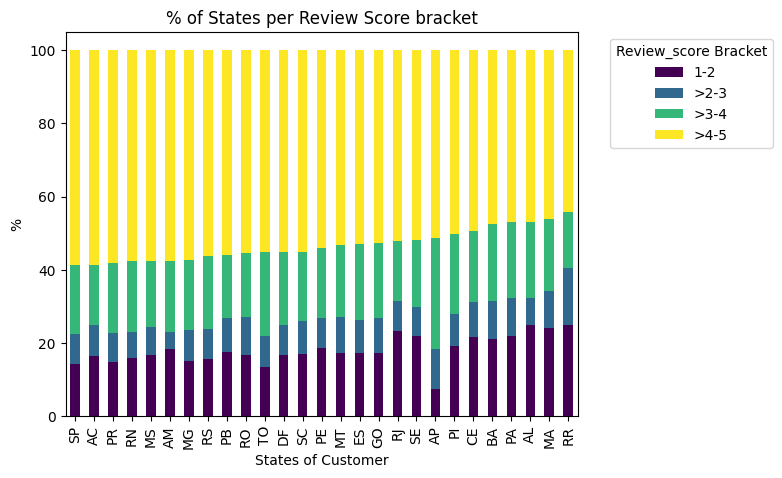

**Books & Media category leads the product categories, with nearly 70% of purchases in this category receiving reviews within the 4-5 score bracket.**

**Surprisingly, other product categories displayed relatively similar success rates, ranging between 58% and 60% for the 4-5 score bracket.**

<Figure size 2000x1200 with 0 Axes>

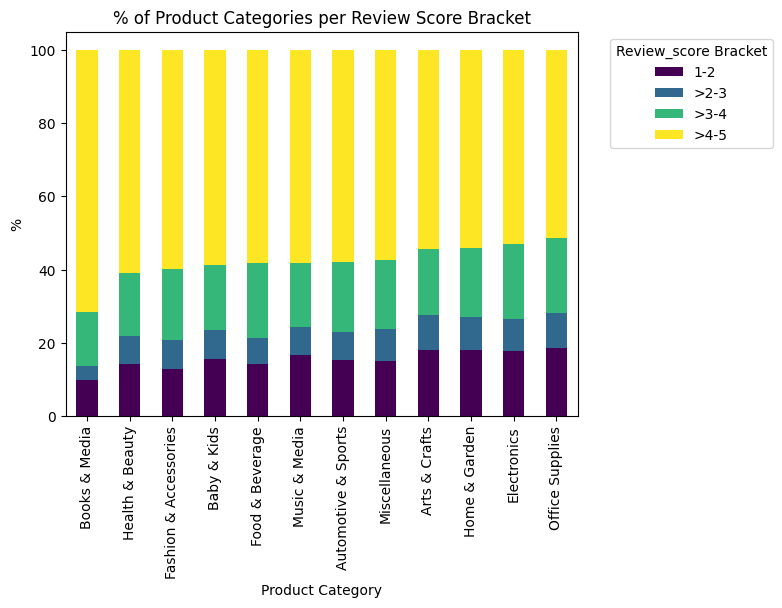

In [95]:



def plot_product_states_scorebrackets(df,index_col, stringtitle,stringlabel,score_bracket_to_sort):
    plt.figure(figsize=(20, 12))  


    pivot_df = df.pivot_table(index=index_col, columns='Score_Bracket', aggfunc='size', fill_value=0)


    pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
    if score_bracket_to_sort in pivot_df.columns:
        pivot_df = pivot_df.sort_values(by=score_bracket_to_sort, ascending=False)


    pivot_df.plot(kind='bar', stacked=True, cmap='viridis')

    plt.title(stringtitle)
    plt.xlabel(stringlabel)
    plt.ylabel('%')
    plt.xticks(rotation=90)
    plt.legend(title='Review_score Bracket', bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.tight_layout()
    plt.subplots_adjust(
    left=0.1,     
    right=0.9,     
    bottom=0.1,    
    top=0.9,       
    wspace=0.3,    
    hspace=0.3     
)
    plt.show()
display(Markdown("**The state of São Paulo demonstrated the highest performance, with nearly 60% of purchase reviews falling within the 4-5 score bracket.**"))
display(Markdown("**Even the lowest-performing state, Roraima, achieved a respectable 42% of purchase reviews in the 4-5 score bracket**"))

plot_product_states_scorebrackets(States_and_Score_Bracket,'Customer_State', '% of States per Review Score bracket','States of Customer','>4-5')
print()
display(Markdown("**Books & Media category leads the product categories, with nearly 70% of purchases in this category receiving reviews within the 4-5 score bracket.**"))
display(Markdown("**Surprisingly, other product categories displayed relatively similar success rates, ranging between 58% and 60% for the 4-5 score bracket.**"))

plot_product_states_scorebrackets(Product_Categories_and_Score_Bracket,'Product_Category', '% of Product Categories per Review Score Bracket','Product Category','>4-5')



In [96]:
# I check the average review score and see if for each customer_unique_id, that specifiy order was the first one
# I would like to see if a customer, after giving less favourable review, will buy again. If yes, how many items and for what price?
# Thats why I join order_items_dataset_table to get the value of transaction
sql_query6 = """
SELECT *
     FROM(
SELECT 
    review.order_id,
    customer_unique_id, 
    customer.customer_id,
    o.order_status,
    o.order_delivered_customer_date, 
    o.order_purchase_timestamp,
    review.review_score, 
    review.review_comment_title,      
    review.review_comment_message, 
    review.review_creation_date,
    review.review_answer_timestamp,
    Round((julianday(review_answer_timestamp) - julianday(review_creation_date)),2) AS difference_in_days_of_answer,
    Round((julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp)),2) AS difference_in_days_of_delivery,
    b.Total_Cost
FROM 
    olist_order_reviews_dataset_table AS review
LEFT JOIN  olist_orders_dataset_table AS o ON review.order_id = o.order_id
LEFT JOIN olist_customers_dataset_table as customer on o.customer_id=customer.customer_id
LEFT JOIN (
           SELECT 
           order_id,
           sum(price) OVER (PARTITION BY order_id) + sum(freight_value) OVER (PARTITION BY order_id) as Total_Cost
           from olist_order_items_dataset_table 
           where order_item_id=1) b on b.order_id=review.order_id) b
"""

conn = sqlite3.connect('OrderList.db')
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS Review_Analysis_Original AS
"""+ sql_query6)

conn.commit()

first_time = pd.read_sql_query(sql_query6, conn)

conn.close()
first_time.head()


,order_id,customer_unique_id,customer_id,order_status,order_delivered_customer_date,order_purchase_timestamp,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,difference_in_days_of_answer,difference_in_days_of_delivery,Total_Cost
0,73fc7af87114b39712e6da79b0a377eb,68a5590b9926689be4e10f4ae2db21a8,41dcb106f807e993532d446263290104,delivered,2018-01-17 18:42:41,2018-01-11 15:30:49,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59,0.91,6.13,198.63
1,a548910a1c6147796b98fdf73dbeba33,64190b91b656ab8f37eb89b93dc84584,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-03-09 23:17:20,2018-02-28 12:25:19,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13,1.13,9.45,88.09
2,f9e4b658b201a9f2ecdecbb34bed034b,1d47144362c14e94ccdd213e8ec277d5,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-16 17:28:48,2018-02-03 09:56:22,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24,1.61,13.31,194.12
3,658677c97b385a9be170737859d3511b,c8cf6cb6b838dc7a33ed199b825e8616,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-20 09:08:35,2017-04-09 17:41:13,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,0.92,10.64,222.84
4,8e6bfb81e283fa7e4f11123a3fb894f1,d16000272660a1fef81482ad75ba572a,5986b333ca0d44534a156a52a8e33a83,delivered,2018-02-28 16:33:35,2018-02-10 10:59:03,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,1.44,18.23,1333.25


In [97]:
# Identify the column representing the acutal customers
unique_counts = first_time.nunique()

display(Markdown("**The Customer_unique_id is associated with the customers. They are assigned different customer_id after each purchase**"))
print(unique_counts)


**The Customer_unique_id is associated with the customers. They are assigned different customer_id after each purchase**

order_id                          99441
customer_unique_id                96096
customer_id                       99441
order_status                          8
order_delivered_customer_date     95664
order_purchase_timestamp          98875
review_score                          5
review_comment_title               4600
review_comment_message            36921
review_creation_date                637
review_answer_timestamp           99010
difference_in_days_of_answer       2632
difference_in_days_of_delivery     5036
Total_Cost                        28286
dtype: int64



**The company demonstrated steady growth starting from Q4 2016, with an average rating of 3.5 points.**
**Until Q3 2017, the review score remained around 4.3, after which orders continued to rise until Q2 2018.**
**However, they were unable to make the quality of service efficient or improve it, so the review score dropped to around 4.**
**The increase in average ratings could only be achieved by a reduction in orders.**
**This lasted only until Q3 2018, after which the number of orders rapidly declined over several quarters, and the rating also dropped.**


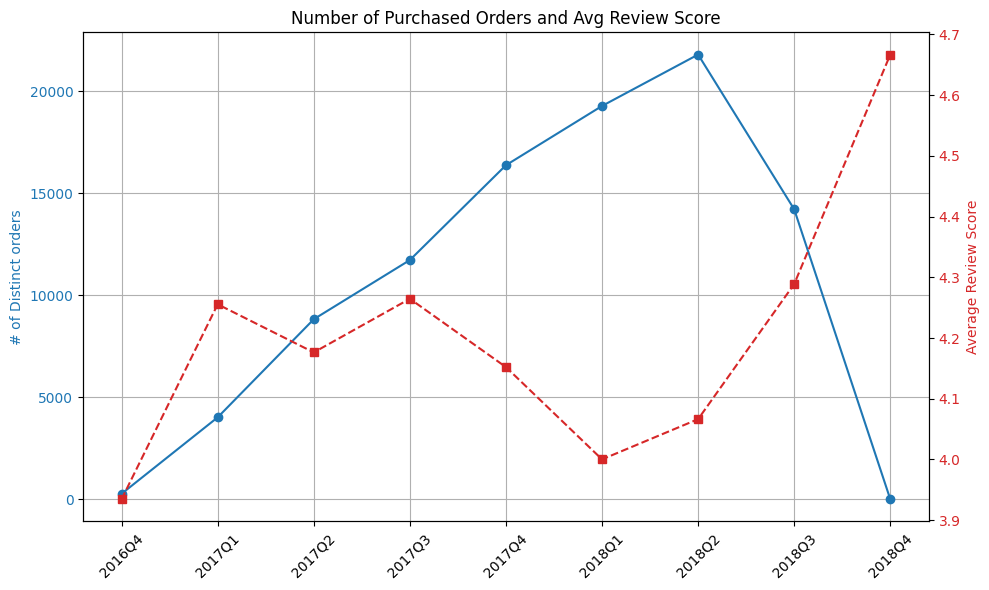

In [98]:
# Did the augmenting orders have any effect on the scores?


first_time['order_delivered_customer_date'] = pd.to_datetime(first_time['order_delivered_customer_date'])


first_time['quarter'] = first_time['order_delivered_customer_date'].dt.to_period('Q')


quarterly_order_count = first_time.groupby('quarter')['order_id'].nunique()

quarterly_avg_score = first_time.groupby('quarter')['review_score'].mean()


fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_ylabel('# of Distinct orders', color=color)
ax1.plot(quarterly_order_count.index.astype(str), quarterly_order_count.values, color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)


ax1.set_xticks(range(len(quarterly_order_count)))
ax1.set_xticklabels(quarterly_order_count.index.astype(str), rotation=45)

ax1.grid(True)

# Creating the second axis (average review score)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Review Score', color=color)
ax2.plot(quarterly_avg_score.index.astype(str), quarterly_avg_score.values, color=color, marker='s', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Number of Purchased Orders and Avg Review Score')
plt.tight_layout()
text = """
**The company demonstrated steady growth starting from Q4 2016, with an average rating of 3.5 points.**
**Until Q3 2017, the review score remained around 4.3, after which orders continued to rise until Q2 2018.**
**However, they were unable to make the quality of service efficient or improve it, so the review score dropped to around 4.**
**The increase in average ratings could only be achieved by a reduction in orders.**
**This lasted only until Q3 2018, after which the number of orders rapidly declined over several quarters, and the rating also dropped.**
"""

display(Markdown(text))
plt.show()


In [99]:


display(Markdown("**By identifying the sequence of each customer's purchases (first, second, third, etc.), the analysis can compare the review scores from their initial purchase to those from subsequent transactions.**"))

**By identifying the sequence of each customer's purchases (first, second, third, etc.), the analysis can compare the review scores from their initial purchase to those from subsequent transactions.**

In [101]:

first_time['order_purchase_timestamp'] = pd.to_datetime(first_time['order_purchase_timestamp'], errors='coerce')


first_time = first_time.sort_values(by=['customer_unique_id', 'order_purchase_timestamp', 'order_id'], ascending=[True, True, True])


first_time['date_diff'] = first_time.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days

first_time['count_purchases'] = (
    first_time['date_diff'].gt(1)  
    .groupby(first_time['customer_unique_id'])  
    .cumsum() + 1  
)

print_first_time = first_time[['order_id', 'customer_unique_id', 'order_purchase_timestamp', 'count_purchases']]
print_first_time.head()



,order_id,customer_unique_id,order_purchase_timestamp,count_purchases
32529,e22acc9c116caa3f2b7121bbb380d08e,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1
32338,3594e05a005ac4d06a72673270ef9ec9,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1
36724,b33ec3b699337181488304f362a6b734,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1
33921,41272756ecddd9a9ed0180413cc22fb6,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1
45983,d957021f1127559cd947b62533f484f7,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1


In [102]:
# Unique_Customers and their associated Average_Score_Bracket. Not by the order but by the unique customers.
display(Markdown("**We separate the orders based on whether they are the first purchase or subsequent purchases. We allocate them score_brackets based on their review score.**"))


from functools import reduce
score_ranges = [(1, 2), (2, 3), (3, 4), (4, 5)]
score_labels = []  

def filter_dataframe(df, filter_value, filter_column, comparison='=='):  

    if comparison == '==':
        filtered_df = df[df[filter_column] == filter_value]
    elif comparison == '>':
        filtered_df  = df[(df[filter_column] > filter_value)]   
    else:
        raise ValueError("Invalid comparison operator. Use '==' or '>'.")
    return filtered_df

def assign_score_brackets(df, filter_value, filter_column, comparison='=='):

    filtered_df = filter_dataframe(df, filter_value, filter_column, comparison=comparison)

    result_df = filtered_df.groupby('customer_unique_id', as_index=False).agg({'review_score': 'mean', 'difference_in_days_of_delivery': 'mean'})


    def get_score_bracket(avg_score):
        for min_score, max_score in score_ranges:
            if min_score <= avg_score <= max_score:
                return f"{min_score}-{max_score}"
        return None  # Ha nincs találat

    result_df['score_bracket'] = result_df['review_score'].apply(get_score_bracket)
    result_df = result_df[['customer_unique_id', 'review_score', 'score_bracket','difference_in_days_of_delivery']]
    return result_df  


result_df = assign_score_brackets(first_time, 1, 'count_purchases', comparison='==')
result_dfreturn = assign_score_brackets(first_time, 1, 'count_purchases', comparison='>')

**We separate the orders based on whether they are the first purchase or subsequent purchases. We allocate them score_brackets based on their review score.**

In [103]:
#Prepare for visualization
#Calculate the total customers per score bracket and the days of delivery for the first timers.

result_df_grouped = result_df.groupby('score_bracket')['customer_unique_id'].nunique().reset_index()
result_df_grouped.rename(columns={'customer_unique_id': 'total_customers'}, inplace=True)

result_delivery = result_df.groupby('score_bracket', as_index=False).agg({ 'difference_in_days_of_delivery': 'mean'})



result_dfreturn_grouped = result_dfreturn.groupby('score_bracket')['customer_unique_id'].nunique().reset_index()
result_dfreturn_grouped.rename(columns={'customer_unique_id': 'total_customers_returning'}, inplace=True)

result_return_delivery = result_dfreturn.groupby('score_bracket', as_index=False).agg({ 'difference_in_days_of_delivery': 'mean'})
result_return_delivery.rename(columns={'difference_in_days_of_delivery': 'difference_in_days_of_delivery_returning'}, inplace=True)

# Merge those dataframes
dataframes = [result_return_delivery, result_delivery, result_df_grouped, result_dfreturn_grouped]

merged_df_basic = reduce(lambda left, right: pd.merge(left, right, on='score_bracket', how='outer'), dataframes)

text = """

**Prepare for visualization: Calculate the total customers per score bracket and the days of delivery for the first timers.**
**We do the aggregation by score_brakcet and the delivery period separately for both datasets, first time buyers and subsquent buyers.**
"""

display(Markdown(text))
merged_df_basic.head()




**Prepare for visualization: Calculate the total customers per score bracket and the days of delivery for the first timers.**
**We do the aggregation by score_brakcet and the delivery period separately for both datasets, first time buyers and subsquent buyers.**


,score_bracket,difference_in_days_of_delivery_returning,difference_in_days_of_delivery,total_customers,total_customers_returning
0,1-2,19.118667,20.300992,14472,265
1,2-3,13.208254,14.279427,8009,161
2,3-4,11.224343,12.321714,18550,345
3,4-5,10.361032,10.684257,55065,1312




**Almost 60% of the first time buyer gave a review score between 4-5 and the delivery was the fastest for them.**
**Around 15% of first time buyers had a devastating experience, giving the company between 1-2 review score.**
**It might not be an accident that the delivery days lasted the longest for those individuals**
**3-4 review score bracket pales in comparison to the 4-5. It is however the second most frequented review score, Slightly ahead of 1-2.**


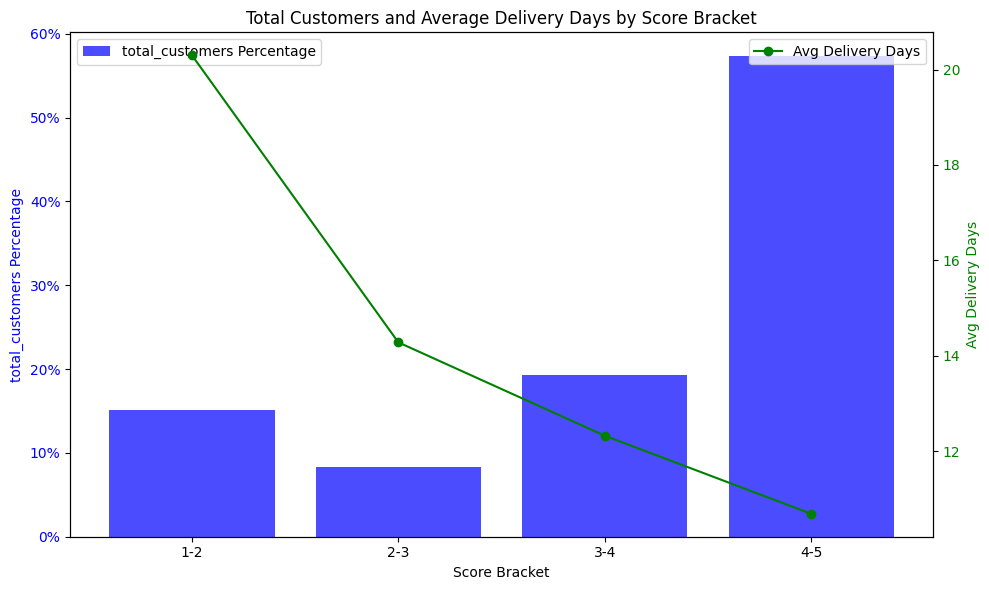



**It seems the ones who were comfortable with their original purchase can be happier for their other purchases, more than 60% of the returning customers gave 4-5 scores.**
**In exchange of the better results within 4-5, the 3-4 group fell back to 18%**
**Less people had a bad experience, 12% of the returning customers reported 1-2 scores**


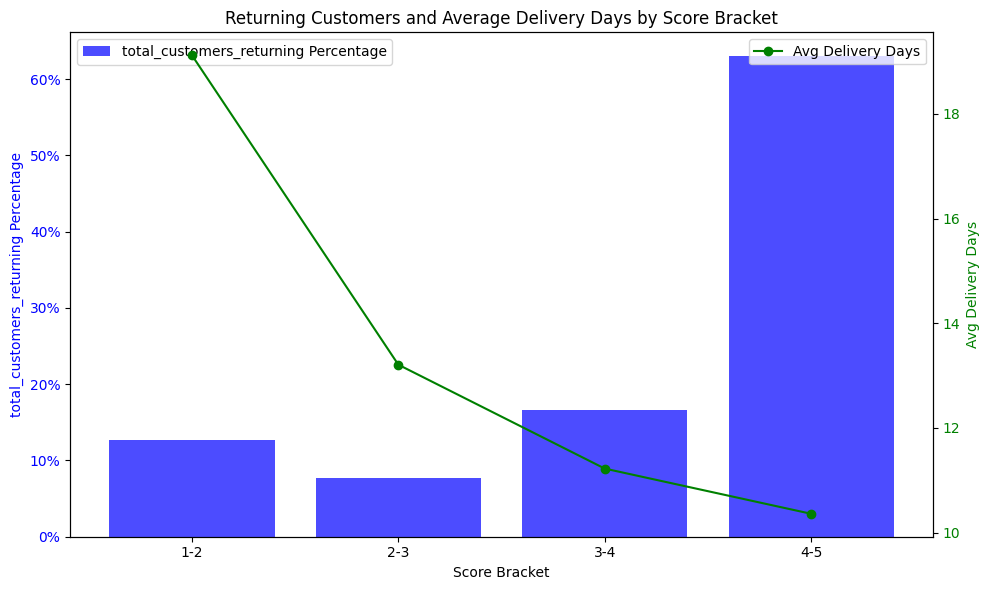

In [104]:

def firsttime_othertime_visual(first_column, second_column, string1, merged_df):
    # Calculate the percentage of total customers relative to the entire DataFrame
    total_customers_sum = merged_df[first_column].sum()
    merged_df[f"{first_column}_pct"]  = (merged_df[first_column] / total_customers_sum) * 100


    x = np.arange(len(merged_df['score_bracket']))

    fig, ax1 = plt.subplots(figsize=(10, 6))


    ax1.bar(x, merged_df[f"{first_column}_pct"], color='blue', alpha=0.7, label=f'{first_column} Percentage')
    ax1.set_xlabel('Score Bracket')
    ax1.set_ylabel(f'{first_column} Percentage', color='blue')
    ax1.set_xticks(x)
    ax1.set_xticklabels(merged_df['score_bracket'])
    ax1.tick_params(axis='y', labelcolor='blue')


    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

    ax1.legend(loc='upper left')

    # Secondary axis: Delivery Days
    ax2 = ax1.twinx()
    ax2.plot(x, merged_df[second_column], color='green', marker='o', linestyle='-', label='Avg Delivery Days')
    ax2.set_ylabel('Avg Delivery Days', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')

    plt.title(string1)
    plt.tight_layout()
    plt.show()
text = """

**Almost 60% of the first time buyer gave a review score between 4-5 and the delivery was the fastest for them.**
**Around 15% of first time buyers had a devastating experience, giving the company between 1-2 review score.**
**It might not be an accident that the delivery days lasted the longest for those individuals**
**3-4 review score bracket pales in comparison to the 4-5. It is however the second most frequented review score, Slightly ahead of 1-2.**
"""

display(Markdown(text))


firsttime_othertime_visual('total_customers', 'difference_in_days_of_delivery', "Total Customers and Average Delivery Days by Score Bracket", merged_df_basic)
text1 = """

**It seems the ones who were comfortable with their original purchase can be happier for their other purchases, more than 60% of the returning customers gave 4-5 scores.**
**In exchange of the better results within 4-5, the 3-4 group fell back to 18%**
**Less people had a bad experience, 12% of the returning customers reported 1-2 scores**
"""

display(Markdown(text1))
firsttime_othertime_visual('total_customers_returning', 'difference_in_days_of_delivery_returning', "Returning Customers and Average Delivery Days by Score Bracket", merged_df_basic)


In [105]:
# Using filters to look for first time customers with 1-2, 2-3, 3-4, 4-5 review scores
display(Markdown("**We would like to investigate the loyalty of the customers from each score brackets.**"))
display(Markdown("**Lets' see how many of them return for more purchases.**"))

def indepth(filter_value):

    filtered_df = result_df[result_df['score_bracket'] == filter_value]
    

    matching_rows = result_dfreturn[result_dfreturn['customer_unique_id'].isin(filtered_df['customer_unique_id'])]
    
    return matching_rows



**We would like to investigate the loyalty of the customers from each score brackets.**

**Lets' see how many of them return for more purchases.**

In [106]:
# Aggregating the filtered data by score bracket
def chart_pract(df):
    result_df_grouped = df.groupby('score_bracket')['customer_unique_id'].nunique().reset_index()
    result_df_grouped.rename(columns={'customer_unique_id': 'total_customers'}, inplace=True)
    result_delivery = df.groupby('score_bracket', as_index=False).agg({ 'difference_in_days_of_delivery': 'mean'})
    merged_df = pd.merge(result_df_grouped, result_delivery, on='score_bracket', how='inner')
    return merged_df


In [107]:
# this function is for calculating the percentages of the returning customers from each score brackets
import matplotlib.pyplot as plt

def perc_calc_returning(df_all, df_filtered, title):

    percentage = round((df_filtered['total_customers'].sum() / df_all.loc[0, 'total_customers']) * 100, 2)
    
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.text(0.5, 0.5, f"{percentage:.2f}%", fontsize=50, ha='center', va='center', color='blue')
    ax.set_title(title, fontsize=10, pad=15)

    ax.axis('off')


    plt.show()




**Nearly 2% of buyers who initially provided ratings of 1-2 after their first purchase returned.**
**Of these, 40% experienced a positive outcome, increasing their ratings to 4-5.**
**However, more than one-third remained dissatisfied, continuing to provide ratings of 1-2.**
**While it is positive that the company has been able to improve its performance, the proportion of**
**1-2 ratings remains concerning.**
**The company should consider promoting its Books & Media products, as this category has**
**demonstrated the best performance according to the initial chart.**



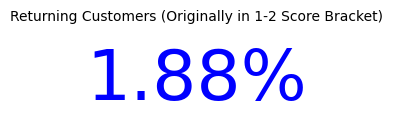

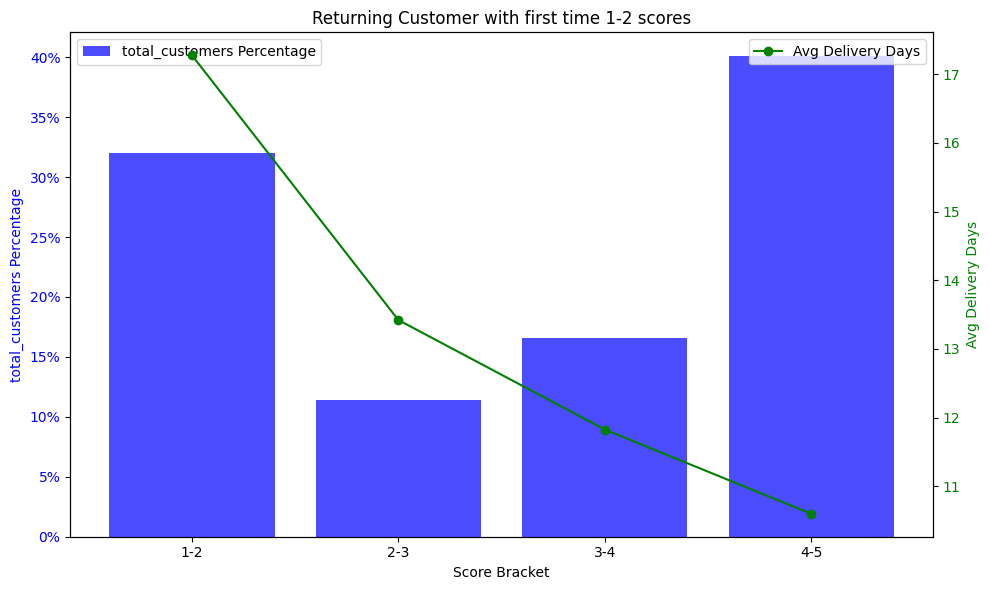

In [108]:
# Visualize using the functions above
text = """

**Nearly 2% of buyers who initially provided ratings of 1-2 after their first purchase returned.**
**Of these, 40% experienced a positive outcome, increasing their ratings to 4-5.**
**However, more than one-third remained dissatisfied, continuing to provide ratings of 1-2.**
**While it is positive that the company has been able to improve its performance, the proportion of**
**1-2 ratings remains concerning.**
**The company should consider promoting its Books & Media products, as this category has**
**demonstrated the best performance according to the initial chart.**

"""

display(Markdown(text))
filtered_df_12 = indepth('1-2')  
merged_df12 = chart_pract(filtered_df_12)  
perc_calc_returning(merged_df_basic, merged_df12, "Returning Customers (Originally in 1-2 Score Bracket)")
firsttime_othertime_visual('total_customers', 'difference_in_days_of_delivery', "Returning Customer with first time 1-2 scores", merged_df12)




**Just over 1% of buyers who initially rated 2-3 after their first purchase returned, which is lower than the previous chart.**
**Of those who returned, 40% saw an improvement, raising their ratings to 4-5. This outcome is similar to that of buyers in the 1-2 rating bracket.**
**However, more than one-third remained dissatisfied, continuing to provide ratings of 1-2 or 2-3.**
**While it is encouraging that the company has managed to improve its performance, the continued proportion of 1-2 and 2-3 ratings remains a cause for concern.**
**The extended delivery times are also concerning, with delays of 24 days and 15 days for the two lowest rating brackets.**
**To address this, clients who provided ratings of 2-3 could be prioritized for faster promotions through more efficient delivery.**




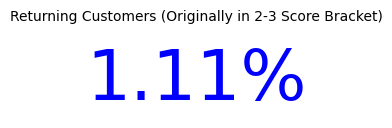

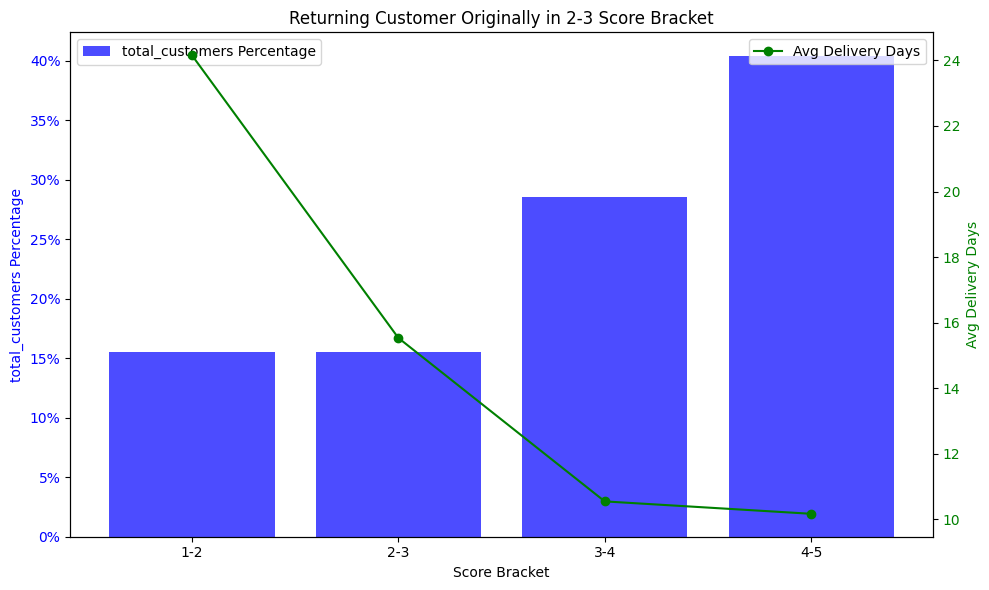

In [109]:
text = """

**Just over 1% of buyers who initially rated 2-3 after their first purchase returned, which is lower than the previous chart.**
**Of those who returned, 40% saw an improvement, raising their ratings to 4-5. This outcome is similar to that of buyers in the 1-2 rating bracket.**
**However, more than one-third remained dissatisfied, continuing to provide ratings of 1-2 or 2-3.**
**While it is encouraging that the company has managed to improve its performance, the continued proportion of 1-2 and 2-3 ratings remains a cause for concern.**
**The extended delivery times are also concerning, with delays of 24 days and 15 days for the two lowest rating brackets.**
**To address this, clients who provided ratings of 2-3 could be prioritized for faster promotions through more efficient delivery.**


"""

display(Markdown(text))
filtered_df_23 = indepth('2-3')
merged_df23=chart_pract(filtered_df_23)
perc_calc_returning(merged_df_basic, merged_df23, "Returning Customers (Originally in 2-3 Score Bracket)")
firsttime_othertime_visual('total_customers', 'difference_in_days_of_delivery', "Returning Customer Originally in 2-3 Score Bracket", merged_df23)



**2.5% of buyers who initially rated 3-4 after their first purchase returned.**
**Of those who returned, almost 50% saw an improvement, raising their ratings to 4-5.**
**Around 20% expreience worse service as they provide ratings of 1-2 or 2-3.**
**While it is encouraging that the company has managed to improve its performance with the astonishing 50% 4-5 ratings, the continued proportion of 1-2 and 2-3 ratings remains a cause for concern.**
**The extended delivery times could also be a contributing factor, with delays of 25 days and 14 days for the two lowest rating brackets.**
**To address this, clients who provided ratings of 2-3 could be prioritized for faster promotions through more efficient delivery as previously**




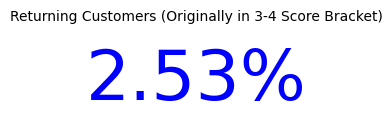

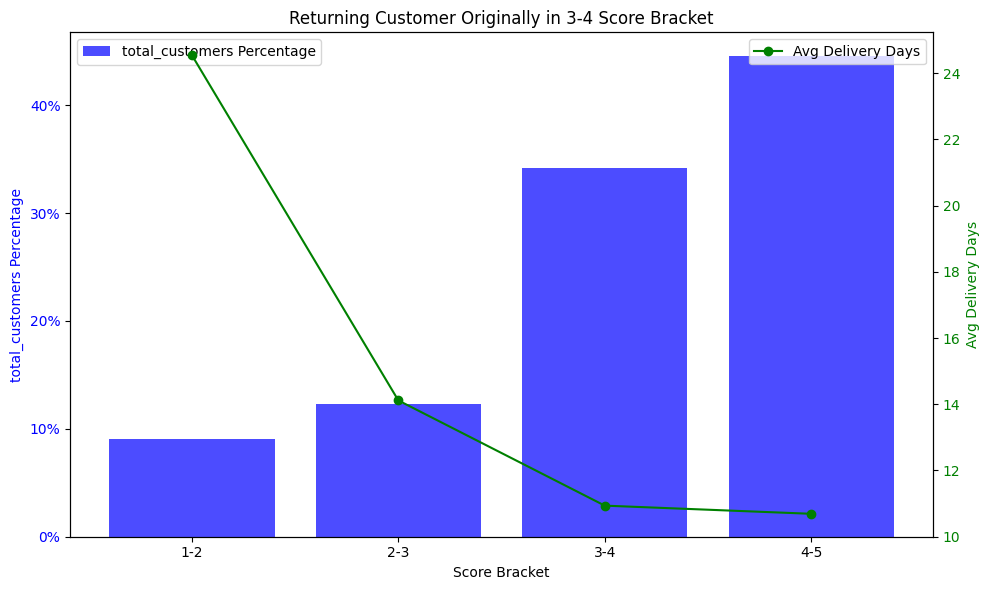

In [110]:
text = """

**2.5% of buyers who initially rated 3-4 after their first purchase returned.**
**Of those who returned, almost 50% saw an improvement, raising their ratings to 4-5.**
**Around 20% expreience worse service as they provide ratings of 1-2 or 2-3.**
**While it is encouraging that the company has managed to improve its performance with the astonishing 50% 4-5 ratings, the continued proportion of 1-2 and 2-3 ratings remains a cause for concern.**
**The extended delivery times could also be a contributing factor, with delays of 25 days and 14 days for the two lowest rating brackets.**
**To address this, clients who provided ratings of 2-3 could be prioritized for faster promotions through more efficient delivery as previously**


"""

display(Markdown(text))
filtered_df_34 = indepth('3-4')
merged_df34=chart_pract(filtered_df_34)
perc_calc_returning(merged_df_basic, merged_df34, "Returning Customers (Originally in 3-4 Score Bracket)")
firsttime_othertime_visual('total_customers', 'difference_in_days_of_delivery', "Returning Customer Originally in 3-4 Score Bracket", merged_df34)



**It is not surprising that nearly 9% of buyers who initially rated 4-5 after their first purchase returned.**
**Among those who returned, almost 80% had a similar experience, maintaining or increasing their ratings to 4-5.**
**However, approximately 22% of them had a negative experience, providing ratings of 1-2, 2-3, or 3-4.**
**In the first two charts comparing customer scores and average delivery delays, the delivery times for the 4-5 rating group were around 10 days.**
**Although the 1-2 rating groups experienced longer delays, averaging 18 days, the rest of the score brackets saw solid delivery performance, ranging from 10 to 11.5 days.**
**The company should be cautious not to lose these satisfied customers. While only 20-22% of them rated below 4 points, it is concerning that these clients, who previously rated 4-5, have lowered their scores.**




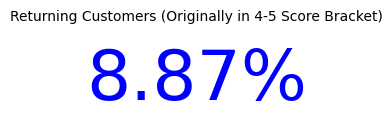

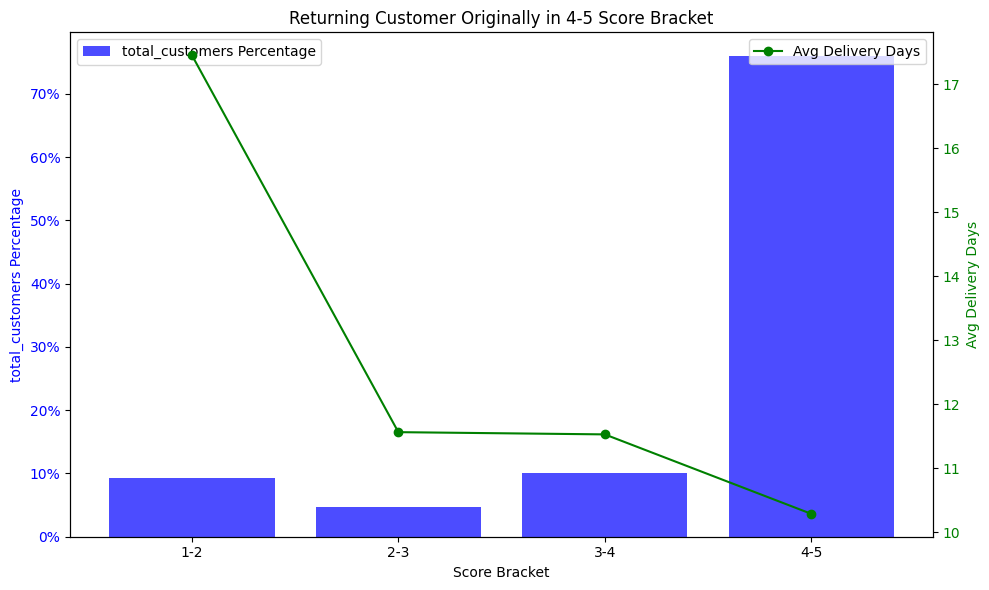

In [111]:
text = """

**It is not surprising that nearly 9% of buyers who initially rated 4-5 after their first purchase returned.**
**Among those who returned, almost 80% had a similar experience, maintaining or increasing their ratings to 4-5.**
**However, approximately 22% of them had a negative experience, providing ratings of 1-2, 2-3, or 3-4.**
**In the first two charts comparing customer scores and average delivery delays, the delivery times for the 4-5 rating group were around 10 days.**
**Although the 1-2 rating groups experienced longer delays, averaging 18 days, the rest of the score brackets saw solid delivery performance, ranging from 10 to 11.5 days.**
**The company should be cautious not to lose these satisfied customers. While only 20-22% of them rated below 4 points, it is concerning that these clients, who previously rated 4-5, have lowered their scores.**


"""

display(Markdown(text))
filtered_df_45 = indepth('4-5')
merged_df45=chart_pract(filtered_df_45)
perc_calc_returning(merged_df_basic, merged_df45, "Returning Customers (Originally in 4-5 Score Bracket)")
firsttime_othertime_visual('total_customers', 'difference_in_days_of_delivery', "Returning Customer Originally in 4-5 Score Bracket", merged_df45)

In [86]:
text = """

**Summary: Only a small percentage of buyers who initially provided low ratings (1-2, 2-3, 3-4) returned for another purchase, but those who did showed improvement in their ratings, particularly in the 1-2 and 2-3 rating brackets.**
**Despite this, a concerning number of customers continued to provide low ratings (1-2 or 2-3), especially in the lower rating brackets (1-2 and 2-3). This signals that the company still faces challenges in improving customer satisfaction consistently across all buyer segments.**
**For these customers, the company should consider diversifying the product offerings and sellers, accompanied by targeted promotions.**
**It’s possible that they continue selecting the same sellers, regions, or items that did not meet their expectations initially.**
**Extended delivery times, particularly for lower-rated brackets (24 days for 1-2 and 15 days for 2-3), could be contributing to dissatisfaction.**
**While higher ratings (4-5) were generally associated with shorter, more acceptable delivery times (around 10 days), delivery delays remain a significant issue.**

**Recommendations for the Future:**
**Promotions: Given that there are products that are performing better than others, the company should consider focusing more on promoting these items**
**especially in targeted marketing campaigns, to ensure better outcomes for returning customers.**
**Focus on Delivery Efficiency: Speeding up delivery times, particularly for those in the lower rating brackets (1-2 and 2-3), should be a priority.**
**Efficient delivery could be a key factor in retaining customers and improving satisfaction across the board.**
**Monitor and Retain Satisfied Customers: The company should closely monitor the 4-5 rating group to prevent any decline in satisfaction.**
**Even though few downgraded their ratings, their loyalty is valuable, so providing consistent, high-quality service is key to retaining them.**


"""

display(Markdown(text))



**Summary: Only a small percentage of buyers who initially provided low ratings (1-2, 2-3, 3-4) returned for another purchase, but those who did showed improvement in their ratings, particularly in the 1-2 and 2-3 rating brackets.**
**Despite this, a concerning number of customers continued to provide low ratings (1-2 or 2-3), especially in the lower rating brackets (1-2 and 2-3). This signals that the company still faces challenges in improving customer satisfaction consistently across all buyer segments.**
**For these customers, the company should consider diversifying the product offerings and sellers, accompanied by targeted promotions.**
**It’s possible that they continue selecting the same sellers, regions, or items that did not meet their expectations initially.**
**Extended delivery times, particularly for lower-rated brackets (24 days for 1-2 and 15 days for 2-3), could be contributing to dissatisfaction.**
**While higher ratings (4-5) were generally associated with shorter, more acceptable delivery times (around 10 days), delivery delays remain a significant issue.**

**Recommendations for the Future:**
**Promotions: Given that there are products that are performing better than others, the company should consider focusing more on promoting these items**
**especially in targeted marketing campaigns, to ensure better outcomes for returning customers.**
**Focus on Delivery Efficiency: Speeding up delivery times, particularly for those in the lower rating brackets (1-2 and 2-3), should be a priority.**
**Efficient delivery could be a key factor in retaining customers and improving satisfaction across the board.**
**Monitor and Retain Satisfied Customers: The company should closely monitor the 4-5 rating group to prevent any decline in satisfaction.**
**Even though few downgraded their ratings, their loyalty is valuable, so providing consistent, high-quality service is key to retaining them.**


